# Homework 04 - Assignment 1 

_Goal_ :

**We want to apply _supervised learning_ to the player-referee dyads dataset, to make predictions on a player skin color given its "description" (see [2 - Skin tone prediction](#2---Skin-tone-prediction)). We will use a RandomForestClassifier to do so, and discuss the results.**

_Tools_ :

**The tools used for this homework are :**
* Pandas
* Scikit Learn

_Contents_ :

* [1 - Importing data](#1---Importing-data)
* [2 - Skin tone prediction](#2---Skin-tone-prediction)
  * [Building the classifier](#Building-the-classifier)
  * [Optimizing hyper parameters](#Optimizing-hyper-parameters)
  * [Inspect features importance](#Inspect-features-importance)
  * [Comparing features importance](#Comparing-features-importance)
  * [BONUS - Learning curves](#BONUS---Learning-curves)

---

First, we make some useful and usual imports.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('notebook')

# 1 - Importing data

## Loading the data

In [2]:
path = './CrowdstormingDataJuly1st.csv'
dyads = pd.read_csv(path)

dyads.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [3]:
print("Number of empty ratings for rater 1 : {}".format(sum(dyads.rater1.isnull())))
print("Number of empty ratings for rater 2 : {}".format(sum(dyads.rater2.isnull())))
print("Number of empty ratings for both : {}".format(sum(dyads.rater1.isnull() & dyads.rater2.isnull())))

Number of empty ratings for rater 1 : 21407
Number of empty ratings for rater 2 : 21407
Number of empty ratings for both : 21407


## Skin tones

We give a quick reminder of the distribution of ratings for each rater :

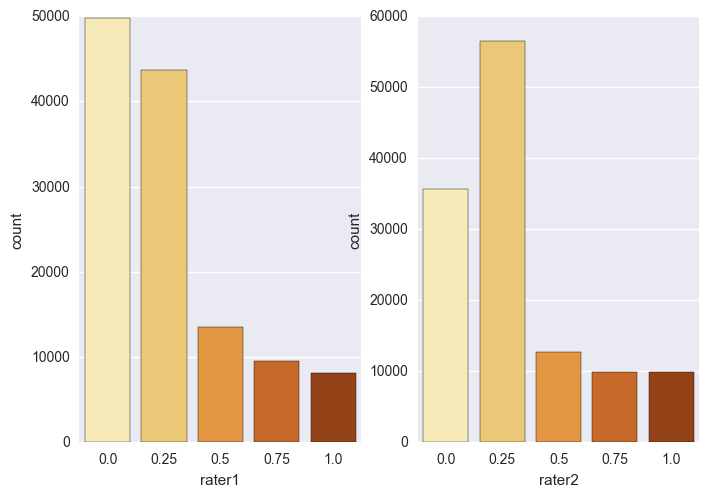

In [4]:
fig, ax = plt.subplots(1,2)
sns.countplot(x='rater1', data=dyads, palette='YlOrBr', ax=ax[0])
sns.countplot(x='rater2', data=dyads, palette='YlOrBr', ax=ax[1])

## Cleaning up a bit

As a last step of preprocessing, we exclude data about referees appearing in less than 22 dyads. Indeed, this is a requirement to say that a referee really officiated at least a match.

In [10]:
referees = dyads.refNum.value_counts()
selected_refNum = referees[referees >= 22].index.values
dyads = dyads[dyads.refNum.isin(selected_refNum)]
dyads.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,1.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


# 2 - Skin tone prediction

In this part, we want to build a RandomForestClassifier that, given a player description outputs his skin color. Now, we have to make clear what we mean by "description" and "skin color".

**Therefore we will make the following operations and assumptions :**

* we will average the skin tone ratings of the two raters and round them to obtain a **binary output / label (0 for light skin, 1 for dark skin)**
* we will **aggregate the dyads by player** and hence say that a row is a player description

Note that this is definitely not the only way to tackle this assignment.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## Building the classifier

First we can drop some columns that we won't use : some obviously won't matter and others are redundant with other columns.

In [12]:
# Drop unnecessary columns and drop NAs
dyads_tmp = dyads.drop(['player', 'club', 'birthday', 'photoID', 'refNum', 'refCountry', 'Alpha_3'], axis=1)
dyads_tmp = dyads_tmp.dropna()

Now let's prepare our data before feeding it to the classifier : we add the rounded average to form the binary output mentioned before, and we can drop the two ratings features (they were just intermediary in this case).

In [13]:
# Add binary labels
dyads_tmp['binarySkin'] = round((dyads_tmp.rater1 + dyads_tmp.rater2)/2)

# Drop intermediary features
dyads_tmp = dyads_tmp.drop(['rater1', 'rater2'], axis=1)

print(dyads_tmp.shape)
dyads_tmp.head()

(105581, 20)


,playerShort,leagueCountry,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,binarySkin
5,aaron-hughes,England,182.0,71.0,Center Back,1,0,0,1,0,0,0,0,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.0
6,aleksandar-kolarov,England,187.0,80.0,Left Fullback,1,1,0,0,0,0,0,0,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.0
7,alexander-tettey,England,180.0,68.0,Defensive Midfielder,1,0,0,1,0,0,0,0,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.0
8,anders-lindegaard,England,193.0,80.0,Goalkeeper,1,0,1,0,0,0,0,0,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.0
9,andreas-beck,Germany,180.0,70.0,Right Fullback,1,1,0,0,0,0,0,0,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.0


Then we aggregate by player and apply `np.mean` to the aggregated data. Again, this is not the only way to do it, we could specify a different function for each feature for example.

In [14]:
players_df = dyads_tmp.groupby('playerShort')
players_df_agg = players_df.agg(np.mean)
players_df_agg.head()

,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,binarySkin
playerShort,,,,,,,,,,,,,,,,,
aaron-hughes,182.0,71.0,4.108974,1.557692,1.128205,1.423077,0.057692,0.121795,0.000000,0.000000,0.344759,20088.589744,0.000333,0.487879,21033.250000,0.001553,0.0
aaron-hunt,183.0,73.0,3.463158,1.473684,0.736842,1.252632,0.621053,0.410526,0.000000,0.010526,0.349332,26877.147368,0.000226,0.453989,27659.842105,0.001025,0.0
aaron-lennon,165.0,63.0,4.079208,1.980198,0.960396,1.138614,0.306931,0.108911,0.000000,0.000000,0.345893,21234.861386,0.000367,0.491482,22238.742574,0.002032,0.0
aaron-ramsey,178.0,76.0,2.591837,1.479592,0.428571,0.683673,0.397959,0.316327,0.000000,0.010204,0.346790,40568.571429,0.000525,0.511650,42088.153061,0.002938,0.0
abdelhamid-el-kaoutari,180.0,73.0,3.351351,1.108108,1.081081,1.162162,0.027027,0.216216,0.108108,0.054054,0.331600,2832.351351,0.001488,0.335587,2953.837838,0.005296,0.0


We create the data matrix $X$ and label vector $y$ and fit a RandomForestClassifier instance.

In [15]:
X = players_df_agg.drop('binarySkin', axis=1)
y = players_df_agg.binarySkin

rfc = RandomForestClassifier()
rfc.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

To have an idea of the performance of the model, we can run cross validation (20-fold) on it :

In [26]:
scores = cross_val_score(rfc, X, y, cv=20, scoring='f1_weighted', n_jobs=4)
print(scores)

[ 0.84126984  0.81684982  0.84126984  0.796875    0.81684982  0.81684982
  0.78724718  0.77053991  0.85865191  0.87546249  0.77922443  0.87488941
  0.86705069  0.82294186  0.75658043  0.85513425  0.83147876  0.85513425
  0.76383929  0.85513425]


## Optimizing hyper parameters

Now, we didn't specify any parameter for our model and hence used default ones. One way to pick a "good" combination of hyperparameters is to run a grid search using cross validation. In this part, we focus on two parameters :
* the number of trees `n_estimators`
* the maximum tree depth `max_depth`

We begin by defining a ranges for the grid search :

In [18]:
# Grid search params
n_trees = list(range(10,200,20))
tree_depth = list(range(10,110,20))
param_grid = dict(n_estimators=n_trees, max_depth=tree_depth)

Then, we can use the `GridSearchCV` utility provided by Scikit-Learn to actually run the grid search. We specify the number of folds `cv` to be 20.

In [27]:
grid = GridSearchCV(rfc, param_grid, cv=20, scoring='f1_weighted', n_jobs=4)
grid.fit(X, y)

/Users/maximepeschard/.pyenv/versions/3.5.2/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/maximepeschard/.pyenv/versions/3.5.2/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/maximepeschard/.pyenv/versions/3.5.2/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/maximepeschard/.pyenv/versions/3.5.2/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/

GridSearchCV(cv=20, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_estimators': [10, 30, 50, 70, 90, 110, 130, 150, 170, 190], 'max_depth': [10, 30, 50, 70, 90]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_weighted', verbose=0)

We can easily display the "best" parameter combination and the associated score.

In [28]:
grid.best_score_

0.83267778784598834

In [29]:
grid.best_params_

{'max_depth': 30, 'n_estimators': 10}

Another way to visualize what's going on is either to display scores as a surface plot (which seems to be rather cumbersome here) or to fix one of the parameters (say by setting it to its "best" value) and plot the scores as a function of the other parameter.

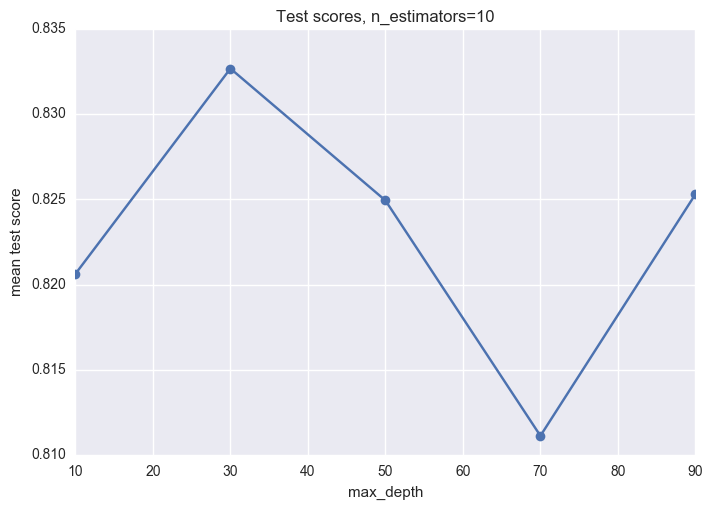

In [30]:
all_params = grid.cv_results_['params']
idx = [all_params.index(p) for p in all_params if p['n_estimators']==grid.best_params_['n_estimators']]
depths = [all_params[i]['max_depth'] for i in idx]
scores = grid.cv_results_['mean_test_score'][idx]

plt.plot(depths, scores, 'o-')
plt.xlabel('max_depth')
plt.ylabel('mean test score')
plt.title('Test scores, n_estimators={}'.format(grid.best_params_['n_estimators']))

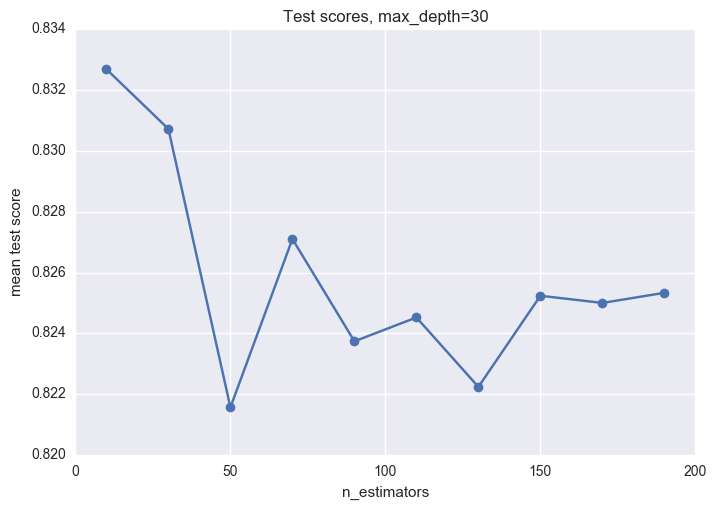

In [31]:
all_params = grid.cv_results_['params']
idx = [all_params.index(p) for p in all_params if p['max_depth']==grid.best_params_['max_depth']]
depths = [all_params[i]['n_estimators'] for i in idx]
scores = grid.cv_results_['mean_test_score'][idx]

plt.plot(depths, scores, 'o-')
plt.xlabel('n_estimators')
plt.ylabel('mean test score')
plt.title('Test scores, max_depth={}'.format(grid.best_params_['max_depth']))

## Inspect features importance

Let's fix the parameters to their values found in the previous section. We now look at the *features importance* of our model.

In [32]:
# Fitting with parameters found previously with grid search
best_n_estimators = grid.best_params_['n_estimators']
best_max_depth = grid.best_params_['max_depth']
rfc = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth)
rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

We can have a glance by plotting directly the `feature_importances_` attribute of the classifier. This tells us roughly which features matter the most (the blue ones) for the classification, and which matter less (the red ones).

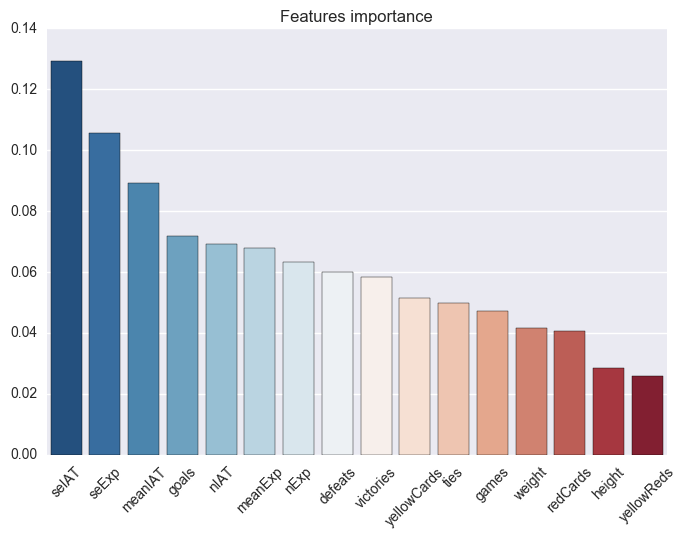

In [33]:
importances = rfc.feature_importances_
sorted_ind = np.argsort(importances)[::-1]
sns.barplot(x=X.columns.values[sorted_ind], y=rfc.feature_importances_[sorted_ind], palette='RdBu_r')
plt.xticks(rotation=45)
plt.title('Features importance')

Going further, we can get more a more detailed view using also the `estimators_` attribute of the classifier which allows us to get the same quantities but for all the decision trees in the forest. We then display the results on a box plot.

In [34]:
feat_importance = pd.DataFrame([tree.feature_importances_ for tree in rfc.estimators_])
feat_importance.columns = X.columns
print(feat_importance.shape)
feat_importance.head()

(10, 16)


,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0.031665,0.036078,0.041547,0.094384,0.039515,0.089079,0.067947,0.053306,0.005302,0.025172,0.097191,0.078825,0.033128,0.070767,0.069667,0.166427
1,0.020537,0.043267,0.025215,0.047217,0.047884,0.132030,0.043059,0.051129,0.009424,0.050945,0.088289,0.075124,0.116531,0.056944,0.030231,0.162175
2,0.040978,0.067021,0.042849,0.046025,0.041603,0.065792,0.104402,0.077749,0.033470,0.007653,0.092749,0.082017,0.041950,0.051179,0.089570,0.114994
3,0.026672,0.041216,0.072824,0.087239,0.031479,0.020027,0.107080,0.044089,0.032311,0.063831,0.063035,0.036629,0.143182,0.099642,0.061557,0.069186
4,0.029611,0.032692,0.061854,0.031473,0.077628,0.044078,0.047570,0.020870,0.035990,0.039520,0.120400,0.040575,0.189870,0.074436,0.090837,0.062596


/Users/maximepeschard/.pyenv/versions/3.5.2/Python.framework/Versions/3.5/lib/python3.5/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

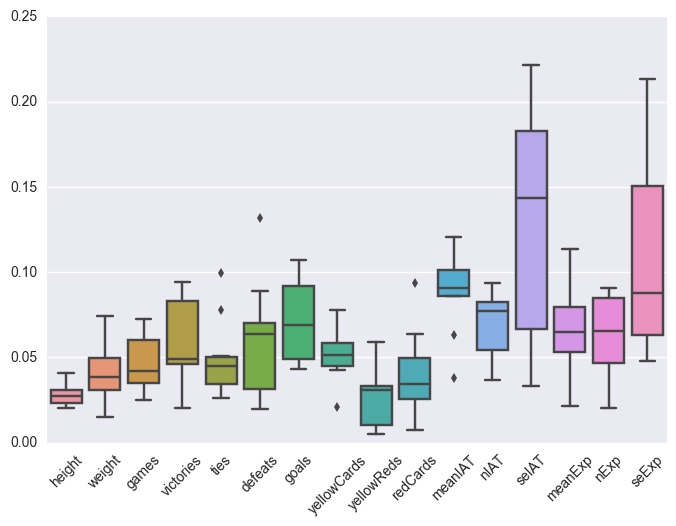

In [35]:
sns.boxplot(feat_importance)
plt.xticks(rotation=45)

## Comparing features importance

In this section, we remove features from the dataset before feeding it to the classifier. Then, we display plots of the same type as before, allowing us to see which features have the most importance.

/Users/maximepeschard/.pyenv/versions/3.5.2/Python.framework/Versions/3.5/lib/python3.5/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

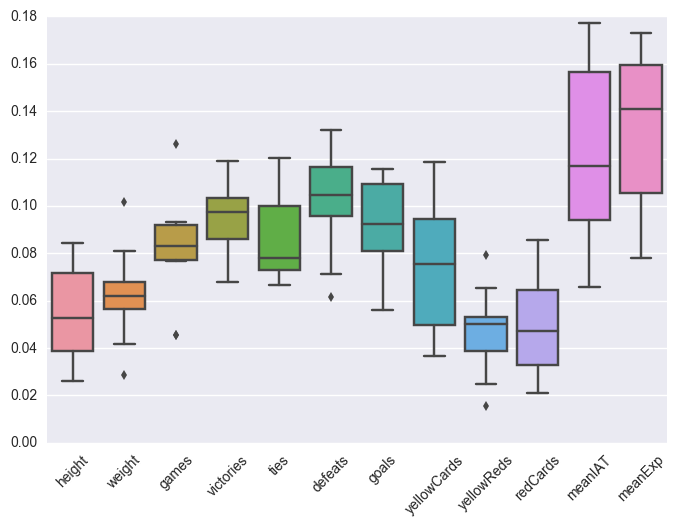

In [36]:
# Dropping the last columns except meanIAT and meanExp
X = players_df_agg.drop(['binarySkin', 'nIAT', 'nExp', 'seIAT', 'seExp'], axis=1)
y = players_df_agg.binarySkin

rfc.fit(X,y)
feat_importance = pd.DataFrame([tree.feature_importances_ for tree in rfc.estimators_])
feat_importance.columns = X.columns
sns.boxplot(feat_importance)
plt.xticks(rotation=45)

/Users/maximepeschard/.pyenv/versions/3.5.2/Python.framework/Versions/3.5/lib/python3.5/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

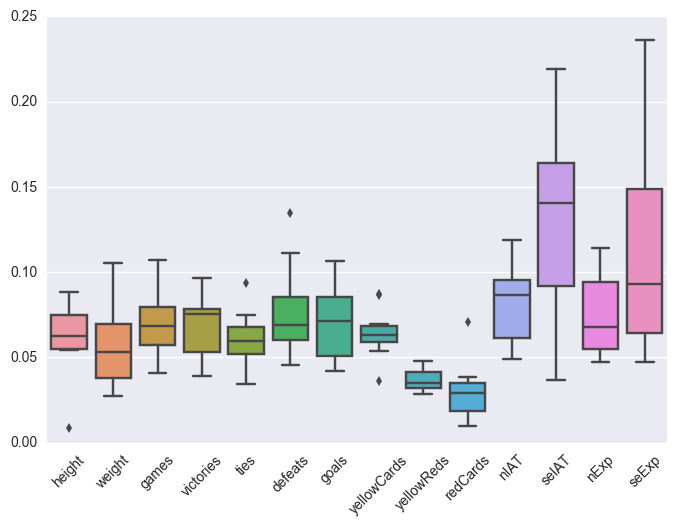

In [37]:
# Dropping meanIAT and meanExp
X = players_df_agg.drop(['binarySkin', 'meanIAT', 'meanExp'], axis=1)
y = players_df_agg.binarySkin

rfc.fit(X,y)
feat_importance = pd.DataFrame([tree.feature_importances_ for tree in rfc.estimators_])
feat_importance.columns = X.columns
sns.boxplot(feat_importance)
plt.xticks(rotation=45)

## BONUS - Learning curves

In this section, we are interested in the *learning curves* for our model. Note that here we use facilities provided by Scikit Learn and plot the *score* as a function of the size of the data (another possibility is to plot the *error* as function of the size of the data, see [slide 55 of lecture 07](https://docs.google.com/presentation/d/1RYFDPzvoUeA4GMyBVGtyX5rUexTN-eSa51NP2YHq3A0/edit?usp=sharing)).

Also, we will use a function `plot_learning_curve` from `helpers.py`, which is taken [from Scikit documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html).

In [38]:
from sklearn.model_selection import learning_curve
from helpers import plot_learning_curve

# We take our "basic" aggregated data.
X = players_df_agg.drop('binarySkin', axis=1)
y = players_df_agg.binarySkin

We are trying to find a set of parameters that leads to *high bias*. If we refer to [lecture 06, slide 46](https://docs.google.com/presentation/d/1lMzCA23k1ya-Qk07JShUWZ563LHaBiGILlg9fgGvQlc/edit?usp=sharing), bias will increase as tree depth decrease. Therefore, we fix our parameter `max_depth` to be a small value (and leave `n_estimators` to a value found earlier).

<module 'matplotlib.pyplot' from '/Users/maximepeschard/.pyenv/versions/3.5.2/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py'>

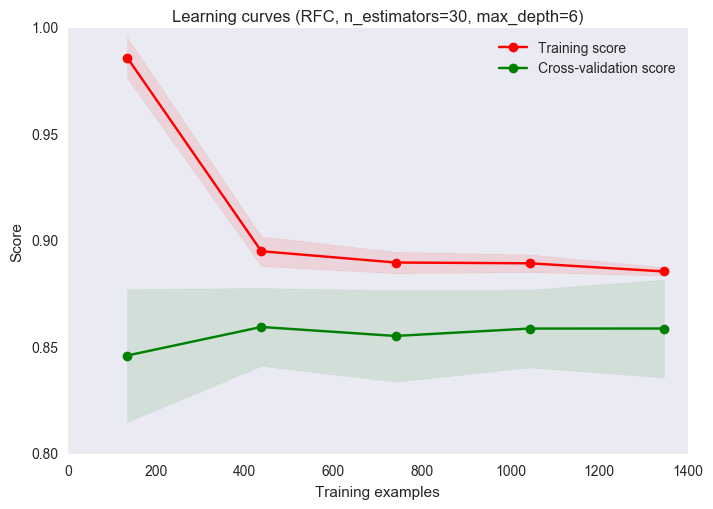

In [39]:
n_estim = 30
max_d = 6
rfc = RandomForestClassifier(n_estimators=n_estim, max_depth=max_d)
title = "Learning curves (RFC, n_estimators={}, max_depth={})".format(n_estim, max_d)
plot_learning_curve(rfc, title, X, y, cv=20, n_jobs=4)

This plot confirms the claim mentioned before : both scores curves "join" and we can see that *adding more data does not help*, hence the high bias.

If we set a higher value for `max_depth` however, this behavior disappear but we have a gap between training and test scores, which indicates variance.

<module 'matplotlib.pyplot' from '/Users/maximepeschard/.pyenv/versions/3.5.2/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py'>

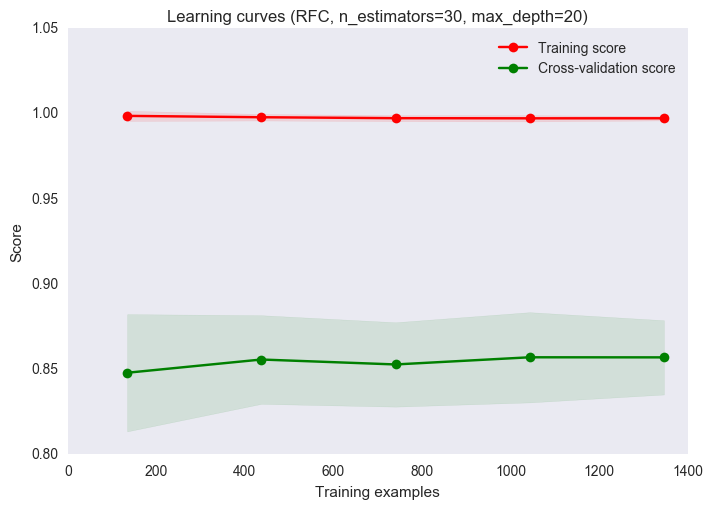

In [40]:
n_estim = 30
max_d = 20
rfc = RandomForestClassifier(n_estimators=n_estim, max_depth=max_d)
title = "Learning curves (RFC, n_estimators={}, max_depth={})".format(n_estim, max_d)
plot_learning_curve(rfc, title, X, y, cv=20, n_jobs=4)